In [12]:
!pip install pandas matplotlib seaborn scipy numpy


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import os   
import math
import warnings
warnings.filterwarnings('ignore')



In [15]:

sns.set(style="whitegrid", context="talk")

csv_path = "/home/aureliaaa/Downloads/PAAD/PAAD/date/dataset_lunar_energie.csv"

# load, parse dates, coerce numerics
df = pd.read_csv(csv_path, parse_dates=["date"], dayfirst=True)
df = df.sort_values("date").reset_index(drop=True)
# keep a datetime index for time-series plots
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.set_index("date")

# coerce all other columns to numeric where possible (NA -> NaN)
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")

In [17]:
# Define numeric columns (exclude date, year, month, and zero-variance columns)
numeric_cols = [c for c in df.select_dtypes(include="number").columns 
                if c not in ("year", "month", "variatio_stocurilor", "rotor_area_m2")]
print(f"Numeric columns: {numeric_cols}")

Numeric columns: ['ALLSKY_SFC_SW_DWN', 'CLOUD_AMT', 'PRECTOTCORR_SUM', 'PS', 'RH2M', 'T2M', 'WS50M', 'producere', 'import', 'procurat_din_alte_surse', 'variatia_stocurilor', 'export', 'consum_final_brut', 'consum_sector_rezidential', 'pv_energy_kwh_day', 'wind_energy_kwh_day']


In [18]:
# Prepare data: remove rows with NaN
data_clean = df[numeric_cols].dropna()
print(f"\nData shape (after removing NaN): {data_clean.shape}")

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_clean)
data_scaled_df = pd.DataFrame(data_scaled, columns=numeric_cols, index=data_clean.index)

print(f"Standardized data shape: {data_scaled_df.shape}")



Data shape (after removing NaN): (126, 16)
Standardized data shape: (126, 16)


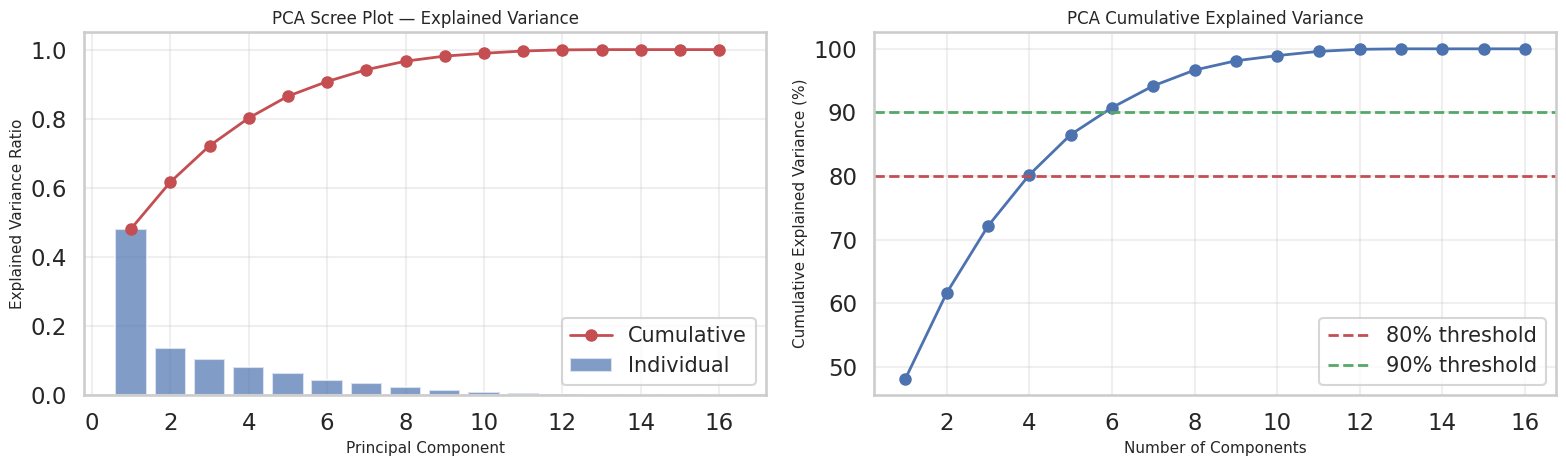


PCA: 4 components explain 80% of variance
PCA: 6 components explain 90% of variance


In [20]:
# 1) PCA - Principal Component Analysis
pca = PCA()
pca_data = pca.fit_transform(data_scaled)

# Explained variance
explained_var = np.cumsum(pca.explained_variance_ratio_)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Scree plot
ax = axes[0]
ax.bar(range(1, len(pca.explained_variance_ratio_) + 1), 
       pca.explained_variance_ratio_, alpha=0.7, color="C0", label="Individual")
ax.plot(range(1, len(explained_var) + 1), explained_var, "ro-", linewidth=2, markersize=8, label="Cumulative")
ax.set_xlabel("Principal Component", fontsize=11)
ax.set_ylabel("Explained Variance Ratio", fontsize=11)
ax.set_title("PCA Scree Plot — Explained Variance", fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(fontsize="small")

# Cumulative variance
ax = axes[1]
ax.plot(range(1, len(explained_var) + 1), explained_var * 100, "bo-", linewidth=2, markersize=8)
ax.axhline(y=80, color="r", linestyle="--", linewidth=2, label="80% threshold")
ax.axhline(y=90, color="g", linestyle="--", linewidth=2, label="90% threshold")
ax.set_xlabel("Number of Components", fontsize=11)
ax.set_ylabel("Cumulative Explained Variance (%)", fontsize=11)
ax.set_title("PCA Cumulative Explained Variance", fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(fontsize="small")

plt.tight_layout()
plt.show()
plt.close(fig)

# Find n_components for 80% and 90%
n_comp_80 = np.argmax(explained_var >= 0.80) + 1
n_comp_90 = np.argmax(explained_var >= 0.90) + 1
print(f"\nPCA: {n_comp_80} components explain 80% of variance")
print(f"PCA: {n_comp_90} components explain 90% of variance")

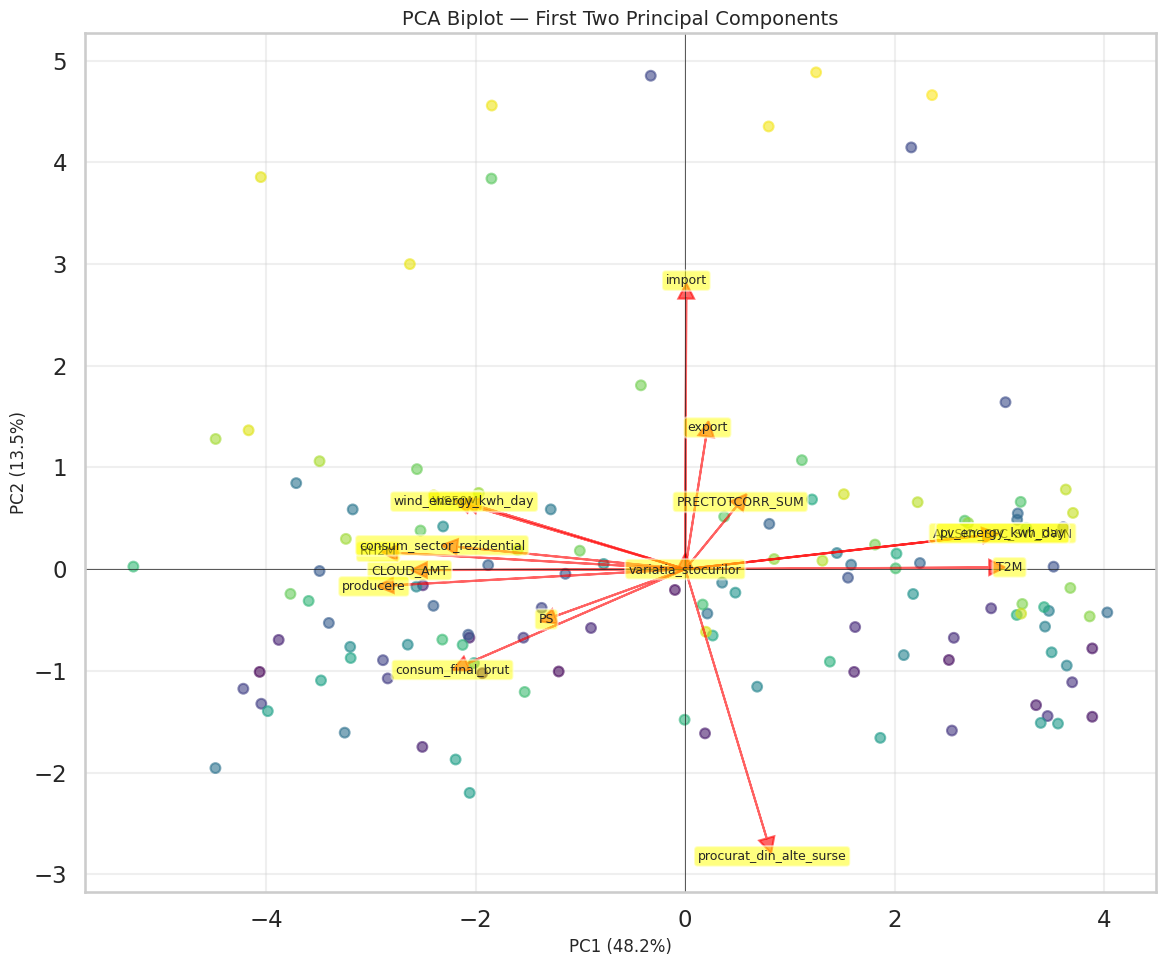

In [21]:
# 2) PCA Biplot (PC1 vs PC2)
fig, ax = plt.subplots(figsize=(12, 10))
pca_2d = PCA(n_components=2)
pca_2d_data = pca_2d.fit_transform(data_scaled)

# Scatter plot of observations
ax.scatter(pca_2d_data[:, 0], pca_2d_data[:, 1], alpha=0.6, s=50, c=range(len(pca_2d_data)), cmap="viridis")

# Plot loading vectors
loadings = pca_2d.components_.T * np.sqrt(pca_2d.explained_variance_)
for i, col in enumerate(numeric_cols):
    ax.arrow(0, 0, loadings[i, 0] * 3, loadings[i, 1] * 3, 
             head_width=0.15, head_length=0.15, fc="red", ec="red", alpha=0.6)
    ax.text(loadings[i, 0] * 3.2, loadings[i, 1] * 3.2, col, fontsize=9, 
            ha="center", va="center", bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))

ax.set_xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)", fontsize=12)
ax.set_ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)", fontsize=12)
ax.set_title("PCA Biplot — First Two Principal Components", fontsize=14)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color="k", linewidth=0.5)
ax.axvline(x=0, color="k", linewidth=0.5)
plt.tight_layout()
plt.show()
plt.close(fig)


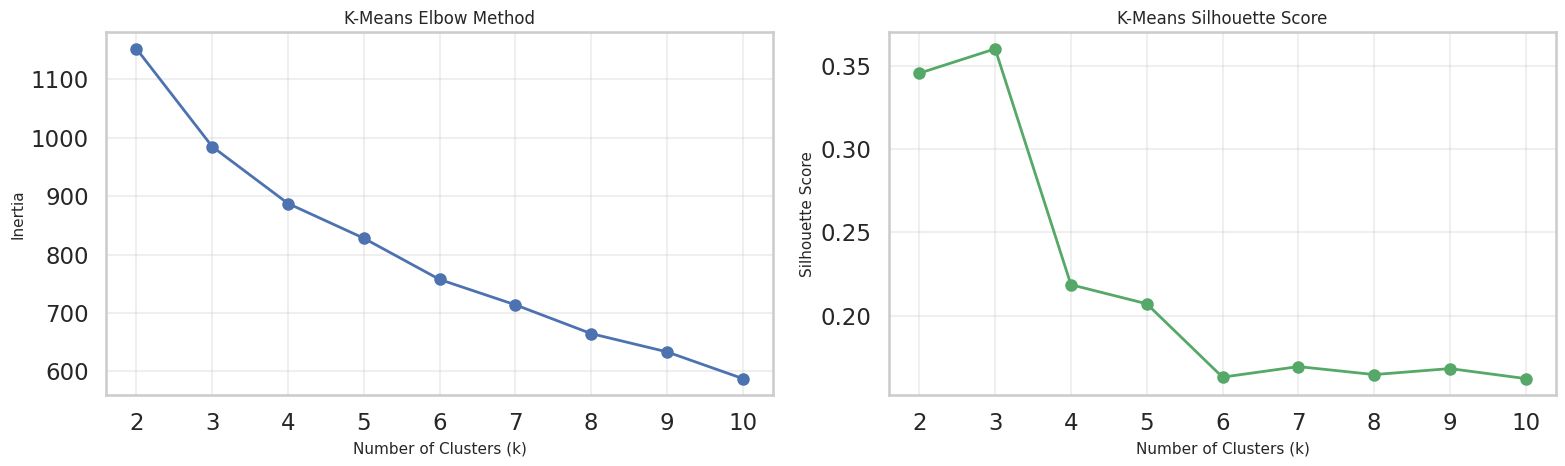


Optimal number of clusters (by silhouette): 3


In [22]:
# 3) K-Means Clustering - Elbow method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

from sklearn.metrics import silhouette_score

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Elbow plot
ax = axes[0]
ax.plot(K_range, inertias, "bo-", linewidth=2, markersize=8)
ax.set_xlabel("Number of Clusters (k)", fontsize=11)
ax.set_ylabel("Inertia", fontsize=11)
ax.set_title("K-Means Elbow Method", fontsize=12)
ax.grid(True, alpha=0.3)

# Silhouette score
ax = axes[1]
ax.plot(K_range, silhouette_scores, "go-", linewidth=2, markersize=8)
ax.set_xlabel("Number of Clusters (k)", fontsize=11)
ax.set_ylabel("Silhouette Score", fontsize=11)
ax.set_title("K-Means Silhouette Score", fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close(fig)

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters (by silhouette): {optimal_k}")

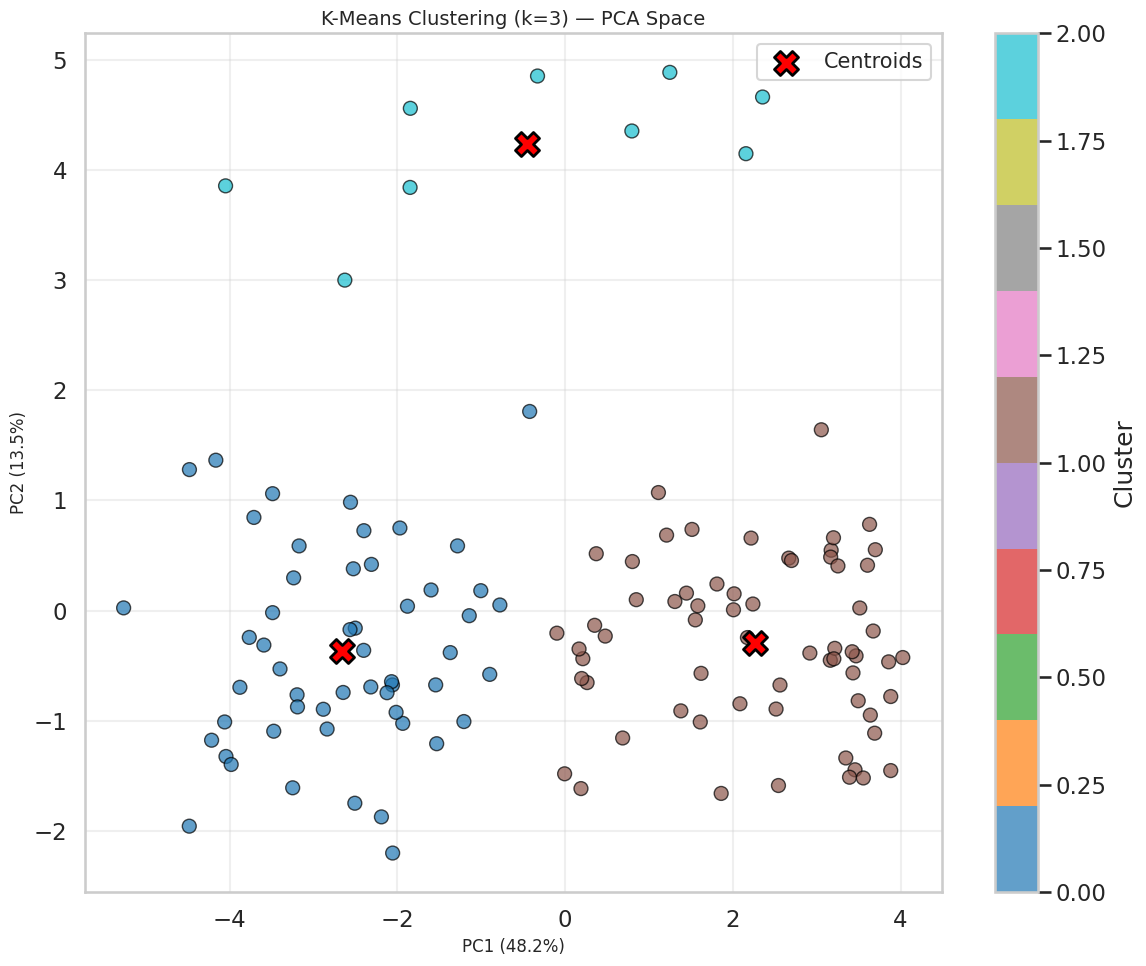

In [23]:
# 4) K-Means clustering with optimal k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(data_scaled)

fig, ax = plt.subplots(figsize=(12, 10))
scatter = ax.scatter(pca_2d_data[:, 0], pca_2d_data[:, 1], c=clusters, cmap="tab10", 
                     s=100, alpha=0.7, edgecolors="black", linewidth=1)
ax.scatter(pca_2d.transform(kmeans_final.cluster_centers_)[:, 0],
          pca_2d.transform(kmeans_final.cluster_centers_)[:, 1],
          c="red", marker="X", s=300, edgecolors="black", linewidth=2, label="Centroids")
ax.set_xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)", fontsize=12)
ax.set_ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)", fontsize=12)
ax.set_title(f"K-Means Clustering (k={optimal_k}) — PCA Space", fontsize=14)
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label="Cluster")
ax.legend(fontsize="small")
plt.tight_layout()
plt.show()
plt.close(fig)


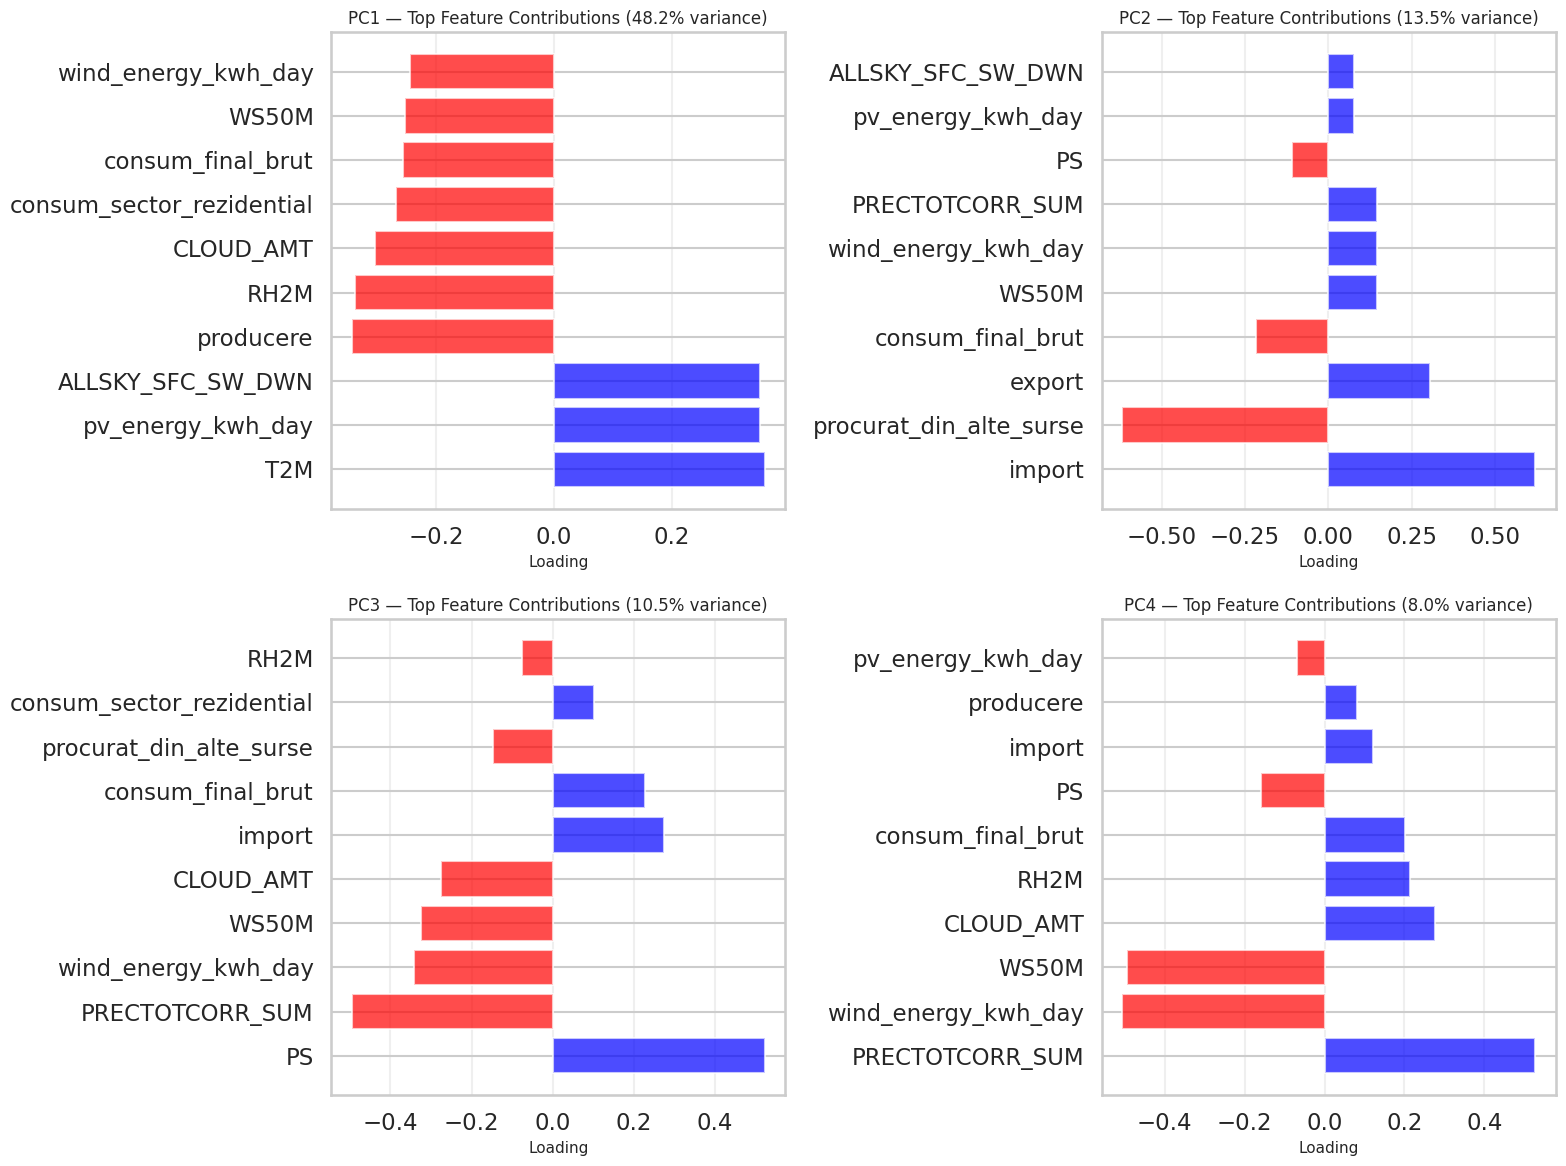

In [25]:
# 6) Feature contributions to PCA components
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx in range(min(4, len(pca.components_))):
    ax = axes[idx]
    loadings = pca.components_[idx]
    sorted_idx = np.argsort(np.abs(loadings))[::-1][:10]  # Top 10
    
    colors = ["red" if x < 0 else "blue" for x in loadings[sorted_idx]]
    ax.barh(np.array(numeric_cols)[sorted_idx], loadings[sorted_idx], color=colors, alpha=0.7)
    ax.set_xlabel("Loading", fontsize=11)
    ax.set_title(f"PC{idx+1} — Top Feature Contributions ({pca.explained_variance_ratio_[idx]*100:.1f}% variance)", fontsize=12)
    ax.grid(True, alpha=0.3, axis="x")

plt.tight_layout()
plt.show()
plt.close(fig)


---

## Pașii Analizei Univariate

**1. Prelucrarea datelor**
- Am încărcat setul de date `dataset_lunar_energie.csv`.
- Am convertit coloana de dată și am setat-o ca index pentru analize temporale.
- Toate coloanele relevante au fost transformate la tip numeric, gestionând valorile lipsă.

**2. Identificarea variabilelor numerice**
- Am selectat variabilele numerice relevante, excluzând coloane neinformative (ex: `year`, `month`, etc.).

**3. Statistici descriptive și meta-informații**
- Pentru fiecare variabilă numerică am calculat: medie, deviație standard, minim, maxim, quartile, skewness, kurtosis, coeficient de variație.
- Am analizat tipul de date, numărul de valori lipsă și numărul de valori unice.

**4. Detectarea outlierilor**
- Am folosit două metode: regula IQR și scorul Z pentru a identifica valorile extreme din fiecare variabilă numerică.

**5. Vizualizări univariate**
Pentru fiecare variabilă numerică am generat:
- Histograme cu KDE și testul de normalitate Shapiro-Wilk, plus valori de skewness și kurtosis.
- Violin plot pentru distribuție.
- Q-Q plot pentru verificarea normalității.
- ECDF plot pentru distribuția cumulativă.
- Boxplot pentru identificarea outlierilor.
- Grafic de trend cu media mobilă pe 12 perioade pentru a observa evoluția temporală.

**6. Vizualizări agregate**
- Am organizat graficele pe tipuri (histograme, violin, Q-Q, ECDF, boxplot, trend) pentru toate variabilele simultan, facilitând comparația între ele.
- Am realizat analiza autocorelației (ACF) pentru a identifica tipare temporale.

---

## Rezultate și Concluzii

- Am obținut o imagine detaliată asupra distribuției fiecărei variabile, gradului de normalitate, prezenței outlierilor și evoluției în timp.
- Majoritatea variabilelor prezintă abateri de la normalitate (skewness/kurtosis semnificative, p < 0.05 la Shapiro-Wilk).
- Outlierii au fost identificați și cuantificați.
- Analiza autocorelației a evidențiat posibile tipare sezoniere sau dependențe temporale.

---

## Metode și Model Analitic

- Statistici descriptive, testul Shapiro-Wilk, regula IQR, scorul Z, vizualizări statistice (histogramă, KDE, violin, Q-Q, ECDF, boxplot, trend), autocorelație (ACF).
- Analiza a fost una exploratorie, bazată pe metode statistice descriptive și vizualizări, fără aplicarea unor modele predictive sau de regresie.

---

## Concluzie

- Datele prezintă variabilitate semnificativă, cu distribuții adesea asimetrice și prezența outlierilor.
- Evoluția temporală și autocorelația indică existența unor tipare sezoniere.
- Analiza univariată oferă o bază solidă pentru investigații ulterioare (bivariată/multivariată) și pentru selecția variabilelor relevante în modele predictive.

---

